## Interpolation 1

**Goal:** We want to encode interpolation into our model, so I'm going to try to 
1. Learn the $m_{hh}$ distribution of one flow
2. Use this learned $m_{hh}$ to map into another flow.

In [72]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from trainFlows import train, validate

import os
os.sys.path.append('../code')
from analysis import *

import os
import sys
sys.path.append("../../pytorch-flows")
import flows as fnn

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Step 1: Load in the data

In [2]:
reload = False
nSelectedJets = 5

subDir = 'data_16_PFlow-MAY2019'
if nSelectedJets != 4:
    subDir += f'-{nSelectedJets}jets'
    
trigger ='2016_triggers'

fDir = f"../data/{subDir}/"

In [3]:
tag = '_NNT_HCs'
fout = f"{fDir}df_f_0.22{tag}.h5"

df = pd.read_hdf(fout,key='df')

In [4]:
df['lead_HC_pt'] = np.where(df.pT_h1>df.pT_h2, df.pT_h1, df.pT_h2)
df['subl_HC_pt'] = np.where(df.pT_h1>df.pT_h2, df.pT_h2, df.pT_h1)

In [5]:
df.kinematic_region

0         -1
1         -1
2         -1
3          2
4         -1
          ..
7496806    2
7496807    2
7496808   -1
7496809   -1
7496810   -1
Name: kinematic_region, Length: 7496811, dtype: int64

In [6]:
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2

Running w/ conda env: don't import root packages.


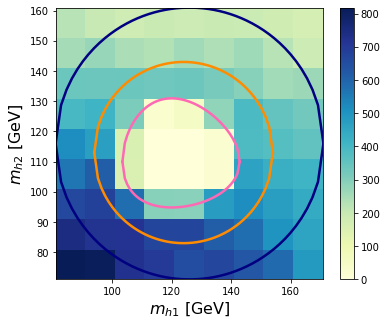

In [7]:
plt.figure(figsize=(6,5))

plt.hist2d(df.loc[(df.ntag==4) & (df.kinematic_region != 0),'m_h1'],
           df.loc[(df.ntag==4) & (df.kinematic_region != 0),'m_h2'],
           9,[[126-45,126+45],[116-45,116+45]],cmap='YlGnBu')

plt.plot(SR_x, SR_y1,'hotpink',linewidth=2.5)
plt.plot(SR_x, SR_y2,'hotpink',linewidth=2.5)

plt.plot(CR_x, CR_y1,'darkorange',linewidth=2.5)
plt.plot(CR_x, CR_y2,'darkorange',linewidth=2.5)

plt.plot(SB_x, SB_y1,'navy',linewidth=2.5)
plt.plot(SB_x, SB_y2,'navy',linewidth=2.5)

plt.xlabel('$m_{h1}$ [GeV]',fontsize=16)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=16)

plt.colorbar()

plt.savefig('figures/interp1/massplane_zoom_4b.pdf')

plt.show()

**What would be nice?**
- Use a R-NVP. to map an $m_{hh}$ distribution from one pixel to another.
- It would *also* be fun to color code this and look at the *evolution* of $m_{hh}$ along a given $m_{h2}$ slice as you flow along $m_{h1}$.
- And then also look at *normalizations* to see how easy this might be to **fit** or what functional form you can use.

In [8]:
colors=['navy','mediumblue','blue','dodgerblue',
        'deepskyblue','darkturquoise','aqua','aquamarine',
        'springgreen','mediumspringgreen','lime',
        'greenyellow','yellow','gold',
        'orange','darkorange','orangered','red','darkred']

In [9]:
len(colors)

19

In [10]:
df.m_h2

0          137.839626
1          126.458954
2          166.750455
3          101.599533
4           87.935848
              ...    
7496806     79.808975
7496807     74.888843
7496808    129.432090
7496809    130.094181
7496810     93.773545
Name: m_h2, Length: 7496811, dtype: float64

In [12]:
116-45

71

In [13]:
mh2_edges = np.linspace(116-45,116+45,10)

mh1_edges = np.linspace(126-45,126+45,10) 
mh1_edges

array([ 81.,  91., 101., 111., 121., 131., 141., 151., 161., 171.])

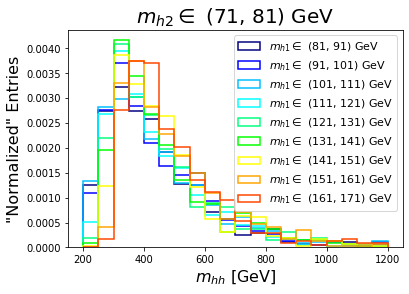

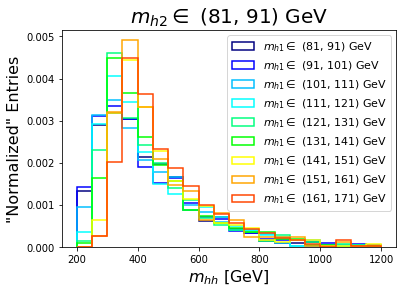

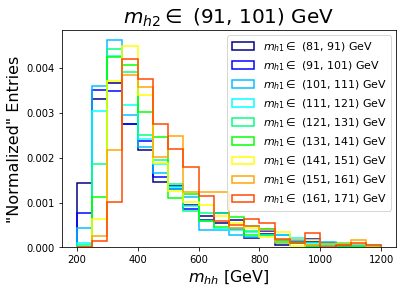

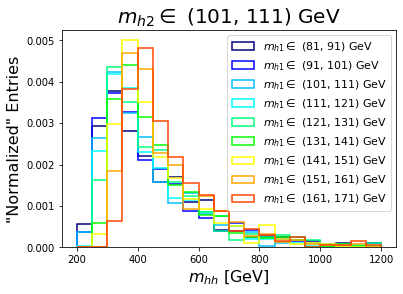

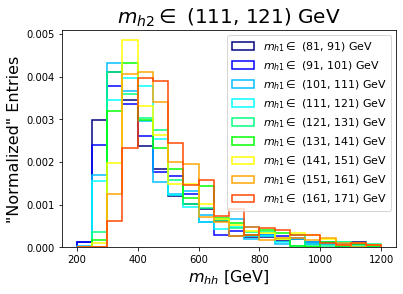

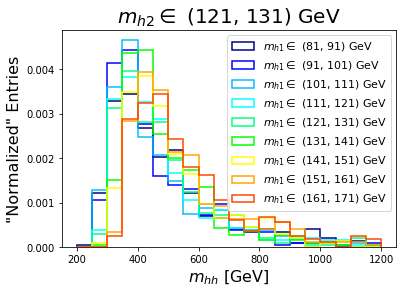

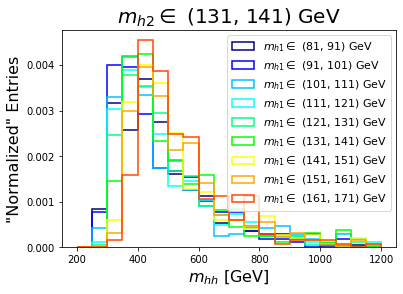

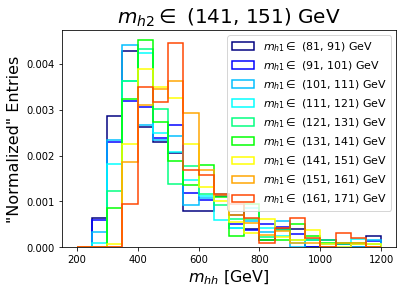

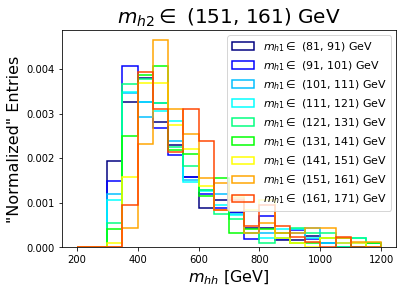

In [14]:
n, mus, stds = {}, {}, {}

for mh2_min, mh2_max in zip(mh2_edges[:-1],mh2_edges[1:]): #= 81,91 #96,101

    mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)

    mh2_tag = f'({mh2_min:.0f}, {mh2_max:.0f}) GeV'
    
    n[mh2_tag], mus[mh2_tag], stds[mh2_tag] = [], [], []

    plt.figure()
    
    for c, mh1_min, mh1_max in zip(colors[::2],mh1_edges[:-1],mh1_edges[1:]):

        mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)
        mask = (df.ntag==4) & mh1_mask & mh2_mask

        mh1_tag = f'({mh1_min:.0f}, {mh1_max:.0f}) GeV'
        
        plt.hist(df.loc[mask,'m_hh'],20,(200,1200), linewidth=1.5,
                 histtype='step',color=c, label = r'$m_{h1} \in$ '+mh1_tag,density=True)

        n[mh2_tag].append(np.sum(mask))
        
        x = np.log(df.loc[mask,'m_hh']-125)
        mus[mh2_tag].append(np.mean(x))
        stds[mh2_tag].append(np.std(x))

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
    plt.ylabel('"Normalized" Entries',fontsize=16)
    plt.title(r'$m_{h2} \in$ '+mh2_tag,fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper right',fontsize=11)

    plt.savefig(f'figures/interp1/mhh_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',bbox_inches='tight')
    
    plt.show()

**Ok - I need to learn how to blind these plots... Max would have kittens**

Let's make a big 9x9 plot with $\log(m_{hh}-125)$ in each bin of the massplane also showing the fitted values. 

In [15]:
import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})

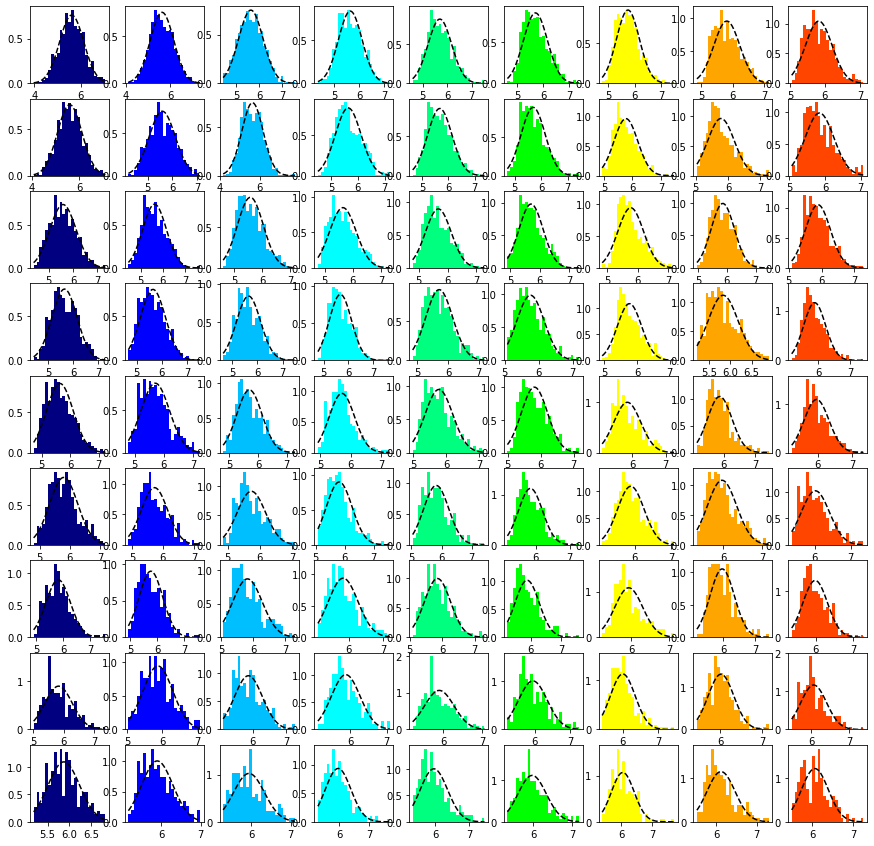

In [16]:
fig, axes = plt.subplots(9,9,figsize=(15,15))

for row, mh2_min, mh2_max in zip(axes,mh2_edges[:-1],mh2_edges[1:]): 

    mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)

    for ax, c, mh1_min, mh1_max in zip(row, colors[::2],mh1_edges[:-1],mh1_edges[1:]):
        
#         x_mid, y_mid = 0.5*(mh1_min+mh1_max), 0.5*(mh2_min+mh2_max)
#         # Blind if the center is in the SR
#         if np.sqrt((10*(x_mid-120)/x_mid)**2 + (10*(y_mid-110)/y_mid)**2) < 1.6:
#             continue
        
        mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)
        mask = (df.ntag==4) & mh1_mask & mh2_mask

        mh1_tag = f'({mh1_min:.0f}, {mh1_max:.0f}) GeV'
        
        x = np.log(df.loc[mask,'m_hh']-125)
        _,e,_ = ax.hist(x,25,color=c,density=True)

        # And do the fit
        mu, std = np.mean(x),np.std(x)
        xi = np.linspace(e[0],e[-1])
        yi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
        ax.plot(xi,yi,'k--')
    
plt.subplots_adjust()
plt.savefig(f'figures/interp1/fit_mhh_9x9_min_mhh_125.pdf',bbox_inches='tight')
plt.show()

**Thoughts:**
- As you move to larger $m_{h2}$ values, the histograms look progressively *less Gaussian*
- I was wondering if maybe this could be because we should be subtracting a different minimum value to generate this distribution.
- I'm going to try it out and see if it looks better!!

In [17]:
np.log(70)

4.248495242049359

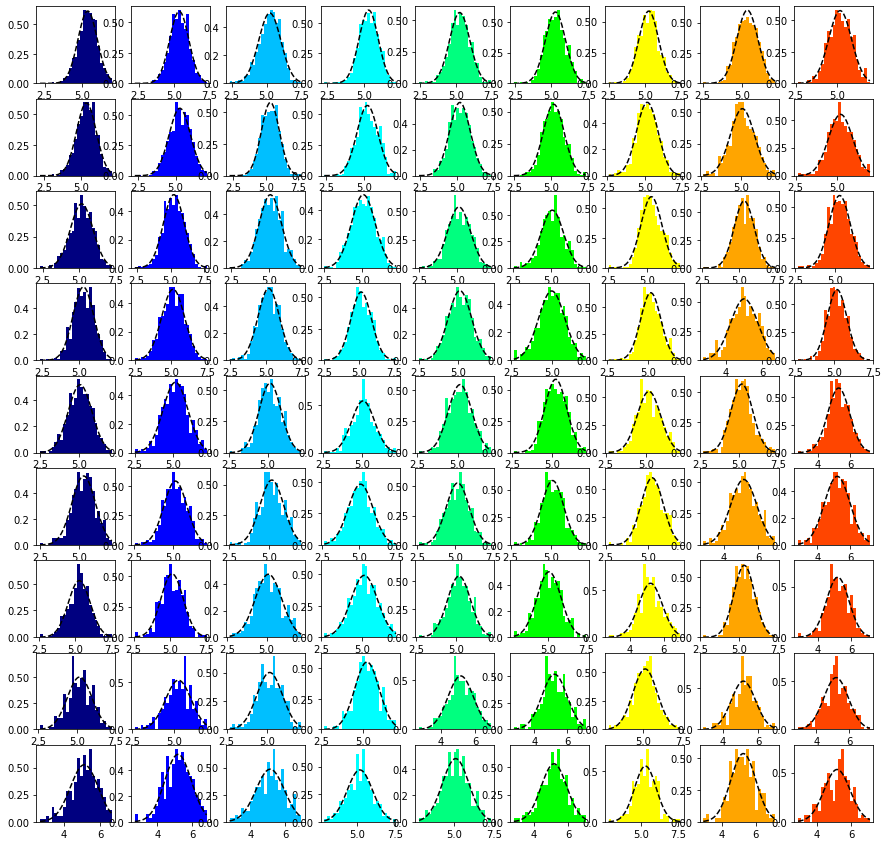

In [18]:
k = .95

mins, mu2, std2 = {}, {}, {}

fig, axes = plt.subplots(9,9,figsize=(15,15))

for row, mh2_min, mh2_max in zip(axes,mh2_edges[:-1],mh2_edges[1:]): 

    mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)

    mh2_tag = f'({mh2_min:.0f}, {mh2_max:.0f}) GeV'
    
    mins[mh2_tag], mu2[mh2_tag], std2[mh2_tag] = [], [], []
    
    for ax, c, mh1_min, mh1_max in zip(row, colors[::2],mh1_edges[:-1],mh1_edges[1:]):
                
        mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)
        mask = (df.ntag==4) & mh1_mask & mh2_mask

        mh1_tag = f'({mh1_min:.0f}, {mh1_max:.0f}) GeV'
        
        mhh_min = np.min(df.loc[mask,'m_hh'])
        
        x = np.log(df.loc[mask,'m_hh']-k*mhh_min)
        _,e,_ = ax.hist(x,25,color=c,density=True)

        # And do the fit
        mu, std = np.mean(x),np.std(x)
        xi = np.linspace(e[0],e[-1])
        yi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
        ax.plot(xi,yi,'k--')
    
        # Save for analysis
        mins[mh2_tag].append(mhh_min)
        mu2[mh2_tag].append(mu)
        std2[mh2_tag].append(std)
    
plt.subplots_adjust()

plt.savefig(f'figures/interp1/fit_mhh_9x9_min_mhh_k_{k}.pdf')
plt.show()

To me - this looks quite a bit better. I guess I'll need to see if this additional parameter $\min(m_{hh})$ is something I can fit?

In [19]:
n.items()

dict_items([('(71, 81) GeV', [818, 814, 726, 701, 652, 669, 631, 590, 487]), ('(81, 91) GeV', [745, 721, 716, 674, 674, 616, 581, 502, 462]), ('(91, 101) GeV', [666, 682, 665, 639, 652, 587, 517, 473, 442]), ('(101, 111) GeV', [563, 614, 551, 586, 546, 541, 513, 431, 414]), ('(111, 121) GeV', [517, 472, 483, 509, 500, 492, 418, 375, 356]), ('(121, 131) GeV', [397, 414, 407, 366, 392, 372, 391, 349, 326]), ('(131, 141) GeV', [340, 338, 339, 333, 337, 319, 296, 258, 266]), ('(141, 151) GeV', [255, 272, 243, 235, 261, 241, 263, 229, 191]), ('(151, 161) GeV', [227, 204, 187, 196, 190, 195, 194, 185, 170])])

In [20]:
from sklearn.linear_model import LinearRegression

Entries / bin
(91, 101) GeV [ True  True  True False False  True  True  True  True]
(101, 111) GeV [ True  True False False False False  True  True  True]
(111, 121) GeV [ True  True False False False False  True  True  True]
(121, 131) GeV [ True  True  True False False  True  True  True  True]
Fitted $\mu$s
(91, 101) GeV [ True  True  True False False  True  True  True  True]
(101, 111) GeV [ True  True False False False False  True  True  True]
(111, 121) GeV [ True  True False False False False  True  True  True]
(121, 131) GeV [ True  True  True False False  True  True  True  True]
Fitted $\sigma$s
(91, 101) GeV [ True  True  True False False  True  True  True  True]
(101, 111) GeV [ True  True False False False False  True  True  True]
(111, 121) GeV [ True  True False False False False  True  True  True]
(121, 131) GeV [ True  True  True False False  True  True  True  True]
$\min(m_{hh})$
(91, 101) GeV [ True  True  True False False  True  True  True  True]
(101, 111) GeV [ True

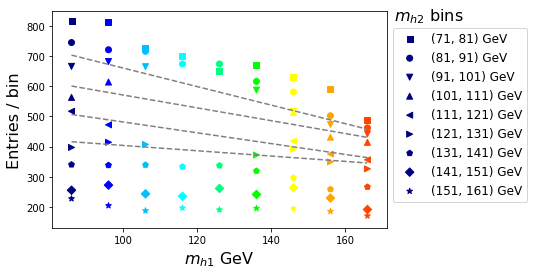

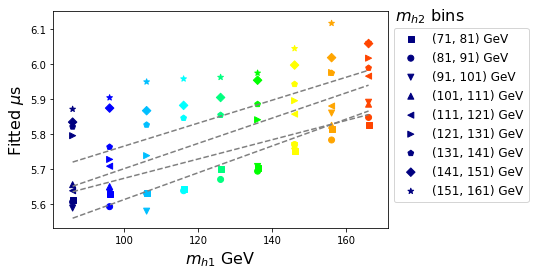

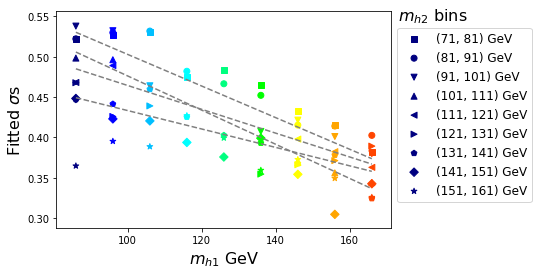

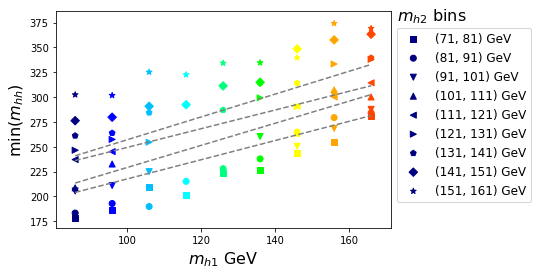

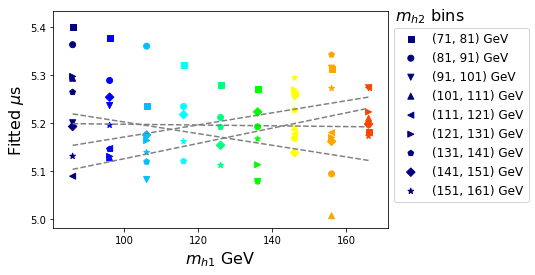

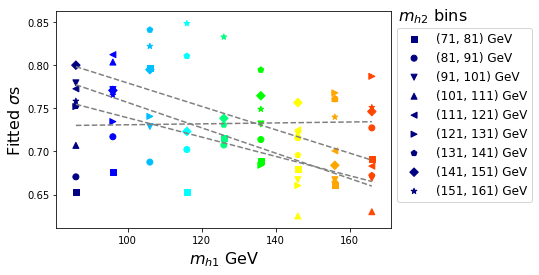

In [21]:
markers = ['s','o','v', "^",'<',">", 'p','D','*']
xi = 0.5*(mh1_edges[:-1]+mh1_edges[1:])

tags = ['n','mu','sigma','min','mu2','std2']
myDict = {t:[] for t in tags}

for d, ylabel, tag, t in zip([n, mus, stds, mins, mu2, std2],
                             ['Entries / bin','Fitted $\mu$s','Fitted $\sigma$s',
                            '$\min(m_{hh})$','Fitted $\mu$s','Fitted $\sigma$s'], 
                             ['entries','mus_125','stds_125','min_mhh',f'mus_k_{k}',f'stds_k_{k}'],
                             tags):
    print(ylabel)
    
    plt.figure()
    for m, (mh2_tag,ni) in zip(markers,d.items()):

        mh2_min = float(mh2_tag.split(', ')[0][1:]) 
        mh2_max = float(mh2_tag.split(', ')[1].split(')')[0])
        yi = 0.5*(mh2_min+mh2_max)
        mask = (np.sqrt((10*(xi-120)/xi)**2+(10*(yi-110)/yi)**2) > 1.6)

        short_colors = [c for mi, c in zip(mask,colors[::2][:9]) if mi]

        plt.scatter(xi[mask],np.array(ni)[mask],color=short_colors,
                    label=mh2_tag,marker=m)

        # If we need to interpolate - do the least squares fit!
        if np.sum(~mask) > 0:
            print(mh2_tag,mask)
            l = LinearRegression().fit(xi[mask].reshape(-1,1),np.array(ni)[mask])
            m, b = l.coef_, l.intercept_
            xj = np.linspace(xi[0],xi[-1])
            nj = m*xj+b
        
            plt.plot(xj,nj,color='grey',linestyle='--',linewidth=1.5)
        
            myDict[t] += list(m*xi[~mask]+b)
        
    # Add a legend
    ax = plt.gca()
    plt.text(1.02,1.02,'$m_{h2}$ bins', ha='left', va='top',
             fontsize=16, transform=ax.transAxes)
    plt.legend(bbox_to_anchor=(1,.95),loc='upper left',fontsize=12)
    plt.xlabel('$m_{h1}$ GeV',fontsize=16)
    plt.ylabel(ylabel,fontsize=16)

    plt.savefig(f'figures/interp1/zoom_{tag}.pdf',bbox_inches='tight')
        
plt.show()

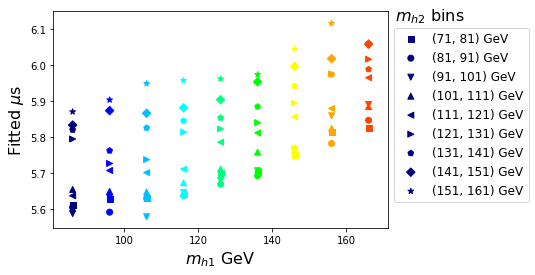

In [22]:
for m, (mh2_tag,ni) in zip(markers,mus.items()):
    plt.scatter(0.5*(mh1_edges[:-1]+mh1_edges[1:]),ni,color=colors[::2][:9],
                label=mh2_tag,marker=m)
    
# Add a legend
ax = plt.gca()
plt.text(1.02,1.02,'$m_{h2}$ bins', ha='left', va='top',
         fontsize=16, transform=ax.transAxes)
plt.legend(bbox_to_anchor=(1,.95),loc='upper left',fontsize=12)
plt.xlabel('$m_{h1}$ GeV',fontsize=16)
plt.ylabel('Fitted $\mu$s',fontsize=16)

plt.show()

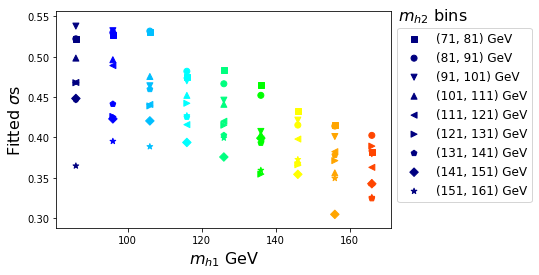

In [23]:
markers = ['s','o','v', "^",'<',">", 'p','D','*']

for m, (mh2_tag,ni) in zip(markers,stds.items()):
    plt.scatter(0.5*(mh1_edges[:-1]+mh1_edges[1:]),ni,color=colors[::2][:9],
                label=mh2_tag,marker=m)
    
# Add a legend
ax = plt.gca()
plt.text(1.02,1.02,'$m_{h2}$ bins', ha='left', va='top',
         fontsize=16, transform=ax.transAxes)
plt.legend(bbox_to_anchor=(1,.95),loc='upper left',fontsize=12)
plt.xlabel('$m_{h1}$ GeV',fontsize=16)
plt.ylabel('Fitted $\sigma$s',fontsize=16)

plt.show()

**Need to blind the above plot!!**


But... it seems interesting that maybe the slope of the "normalization line" is a function of $m_{h2}$ (or $1/m_{h2}$)? Anyways... fun stuff!!

## Next step: Train a Real-NVP for *one* bin

1. Preprocess the training data
2. Train for an epochs
3. Evaluate the results

**Question** Should I take the `log` of $m_{hh}$ before predicting its density??

In [24]:
mh1_min,mh1_max = 81,91
mh2_min,mh2_max = 81,91

mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)
mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)

mask = (df.ntag==4) & mh1_mask & mh2_mask

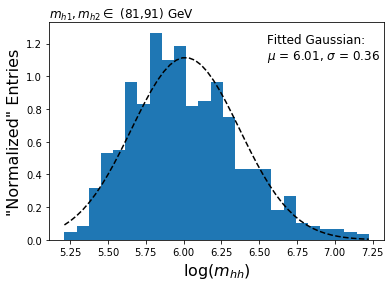

In [25]:
x = np.log(df.loc[mask,'m_hh'])
N = np.sum(mask)

_,e,_ = plt.hist(x,25,density=True)
plt.xlabel('$\log (m_{hh})$',fontsize=16)
plt.ylabel('"Normalized" Entries',fontsize=16)

ax = plt.gca()

mu, std = np.mean(x),np.std(x)
xi = np.linspace(e[0],e[-1])
yi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
plt.plot(xi,yi,'k--')

text = f'Fitted Gaussian:\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}'
plt.text(.65,.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

# Also add the (mh1,mh2) tag to the plot
mh_tag = '$m_{h1},m_{h2} \in$ '+f'({mh1_min:.0f},{mh1_max:.0f}) GeV'
plt.text(0,1,mh_tag,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig(f'figures/interp1/log_mhh_mh1_{mh1_min:.0f}_{mh1_max:.0f}_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',
            bbox_inches='tight')

plt.show()

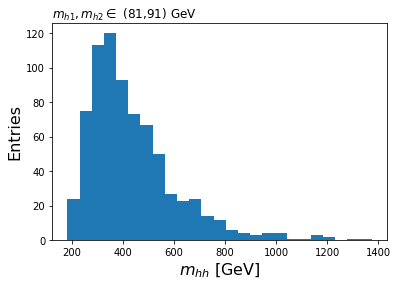

In [26]:
plt.hist(df.loc[mask,'m_hh'],25)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Entries',fontsize=16)

ax=plt.gca()
plt.text(0,1,mh_tag,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig(f'figures/interp1/mhh_mh1_{mh1_min:.0f}_{mh1_max:.0f}_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',
            bbox_inches='tight')

plt.show()

It could be that it's more useful to subtract some constant from $m_{hh}$ before taking the log?

In [27]:
print('2b',np.min(df.loc[(df.ntag == 2)&(df.m_h1 > 81)&(df.m_h1 > 71),'m_hh']))
print('3b',np.min(df.loc[(df.ntag >= 3)&(df.m_h1 > 81)&(df.m_h1 > 71),'m_hh']))
print('4b',np.min(df.loc[(df.ntag >= 4)&(df.m_h1 > 81)&(df.m_h1 > 71),'m_hh']))

2b 129.56756075307223
3b 127.14888012491068
4b 145.47271548138167


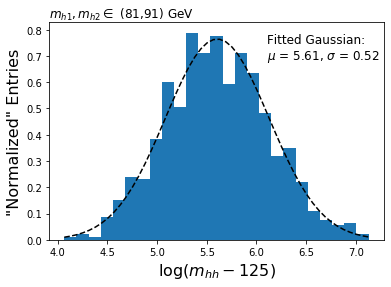

In [28]:
x = np.log(df.loc[mask,'m_hh']-125)
N = np.sum(mask)

_,e,_ = plt.hist(x,25,density=True)
plt.xlabel('$\log (m_{hh}-125)$',fontsize=16)
plt.ylabel('"Normalized" Entries',fontsize=16)

ax = plt.gca()

mu, std = np.mean(x),np.std(x)
xi = np.linspace(e[0],e[-1])
yi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
plt.plot(xi,yi,'k--')

text = f'Fitted Gaussian:\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}'
plt.text(.65,.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.text(0,1,mh_tag,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig(f'figures/interp1/mhh_mh1_{mh1_min:.0f}_{mh1_max:.0f}_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',
            bbox_inches='tight')

plt.show()


Maybe a real NVP isn't even necessary if all I need to find are the $\mu$ and $\sigma$s for the corresponding Gaussians? (Worth a shot anyways!!)

In [29]:
25/(e[-1]-e[0])

8.157583193977127

Ok - this is pretty cool (actually): let's get a distribution!!

In [30]:
myDict['mu'],myDict['sigma']

([5.673902653246384,
  5.712214887200491,
  5.689866016156042,
  5.717423268026253,
  5.7449805198964645,
  5.772537771766675,
  5.722634945058115,
  5.7587477969140695,
  5.794860648770024,
  5.830973500625979,
  5.817883966683884,
  5.850701243561483],
 [0.471464832623015,
  0.45190154803819926,
  0.46341755623465897,
  0.4422775619063908,
  0.42113756757812254,
  0.39999757324985435,
  0.4554442087177616,
  0.4407006441961999,
  0.4259570796746383,
  0.41121351515307664,
  0.4150102318395855,
  0.4036122207548708])

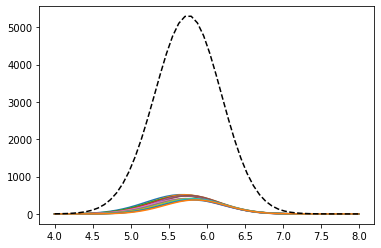

In [31]:
xk = np.linspace(4,8)
y  = np.zeros_like(xk) 

for n, mu, sigma in zip(myDict['n'],myDict['mu'],myDict['sigma']):
    
    yk = n/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((xk-mu)/sigma)**2)
    y+=yk
    
    plt.plot(xk,yk)
    
plt.plot(xk,y,'k--')
plt.show()  

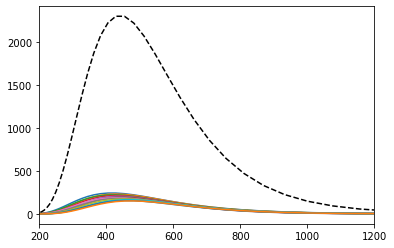

In [32]:
mk = 125+np.exp(xk)
y  = np.zeros_like(xk) 

for n, mu, sigma in zip(myDict['n'],myDict['mu'],myDict['sigma']):
    
    yk = sigma*n/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((xk-mu)/sigma)**2)
    y += yk
    
    plt.plot(mk,yk)
    
plt.plot(mk,y,'k--')
plt.xlim(200,1200)
plt.show()  

I think there's a change of variables formula that I might also need to account for... let's look inside the `NAF` notebook!!

In the NAF nb - it looked like this was how it was done, but I'm not sure.

- Should I try to pull a limit out next?
- Or repeat the studies with 2b where I'm allowed to pull open the curtain?
- Or peak and look at 4b (because 2016 has already been analyzed anyways)?

### To do:
- Let's add some text to these plots to indicate which ($m_{h1}$,$m_{h2}$) bin we're in.
- Try fitting a Gaussian to both $\log m_{hh}$ and $\log ( m_{hh} - 125)$

In [33]:
df['m_hh_125'] = df['m_hh'] - 125
df['m_hh_125_log'] = np.log(df['m_hh_125'])

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
class hh4bDataset(Dataset):
    
    def __init__(self, df, cols=['m_hh_125_log'], cond_cols=[],  
                 ntag=4, bin_mask=None, bin2_mask=None, plane_mask=None):
        """
        
        Inputs:
        - df: The pandas Dataframe
        - cols: The input variables of interest
        
        """

                
        # Fit the full plane - but transform the individual pixel
        scalarX = StandardScaler()
        x_plane = df.loc[(df.ntag == ntag) & plane_mask,cols].values
        scalarX.fit(x_plane)
        
        x_bin = df.loc[(df.ntag == ntag) & bin_mask,cols].values
        x = scalarX.transform(x_bin,copy=True)
        
        self.x = x
        self.scalarX = scalarX
        
        if bin2_mask is not None:
            x2_bin = df.loc[(df.ntag == ntag) & bin2_mask,cols].values  
            self.x2 = scalarX.transform(x2_bin,copy=True)
        else:
            self.x2 = None
            
        if len(cond_cols) > 0:
            
            y_unnorm = df[cond_cols].values
        
            scalarY = StandardScaler()
            scalarY.fit(y_unnorm)
            y = scalarY.transform(y_unnorm,copy=True)

            self.y = y
            self.scalarY = scalarY
            self.cond = True
                
        else:
            self.cond = False
        
        
    def __len__(self):
        return self.x.shape[0] 

    def __getitem__(self, idx):
        
        if self.cond:
            return self.x[idx], self.y[idx]
        elif self.x2 is None:
            return self.x[idx]
        else:
            return self.x[idx], self.x2[idx]
             

In [60]:
def getDataLoaders(df, cols=['m_hh_125_log'], cond_cols=[],  ntag=4, 
                   bin_mask=None, bin2_mask=None, plane_mask=None,
                   batch_size=128, returnScalar=False):
    '''
    Inputs: 
    - df: The pandas Dataframe
    - cols: The input variables of interest
    -batch_size: default 128
    -N: Number of events to load in, the default value of -1  
 
    Returns: loader_train, loader_val
        DataLoaders for the train and val sets
 
    '''
        
    dset = hh4bDataset(df, cols=cols, cond_cols=cond_cols, ntag=ntag, 
                       bin_mask=bin_mask, bin2_mask=bin2_mask, plane_mask=plane_mask)

    trainFrac=.8
    nEvts = len(dset)
        
    idxTrain = [j for j in range(int(trainFrac*nEvts))]
    idxVal   = [j for j in range(int(trainFrac*nEvts), nEvts)]
    
    loader_train = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxTrain))
    loader_val = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxVal))
    
    if len(cond_cols) > 0:
        scalars = dset.scalarX, dset.scalarY
    else:
        scalars = dset.scalarX
    
    if returnScalar:
        return loader_train, loader_val, scalars
    else:
        return loader_train, loader_val

In [58]:
mh1_min,mh1_max = 81,91
mh2_min,mh2_max = 81,91

mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)
mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)

bin_mask = mh1_mask & mh2_mask
bin2_mask = (df.m_h1 > mh1_max) & (df.m_h1 < mh1_max+10) & mh2_mask

In [37]:
mh1_min,mh1_max = 81,171
mh2_min,mh2_max = 71,161

mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)
mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)

plane_mask = mh1_mask & mh2_mask

In [38]:
np.sum((df.ntag==4)&plane_mask)

36161

In [39]:
loader_train, loader_val = getDataLoaders(df, ntag=4, bin_mask=bin_mask, 
                                          plane_mask=plane_mask)

In [40]:
%%bash
nvidia-smi

Wed Apr  8 11:34:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 25%   33C    P2    54W / 250W |    585MiB / 11178MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 20%   30C    P0    59W / 250W |      0MiB / 12196MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  G

In [41]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Set up the basic model.

In [42]:
mask = torch.ones([1]) 
mask = mask.unsqueeze(0).float().to(device)

In [47]:
modules = []

num_inputs = 1
num_hidden = 64
num_cond_inputs = None

for _ in range(1):
        modules += [
            fnn.CouplingLayer(num_inputs, num_hidden, mask, num_cond_inputs),
            fnn.BatchNormFlow(num_inputs)
        ]
               
model = fnn.FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [48]:
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model
global_step = 0

nEpochs = 5
losses = {key: [] for key in ['train','val']}

modelName = "models/rnvp_m_hh_125_log_bin.pt"

for epoch in range(nEpochs):
    print('\nEpoch: {}'.format(epoch))

    train_loss = train(epoch, model, loader_train, device, optimizer)
    losses['train'].append(train_loss)
    validation_loss = validate(epoch, model, loader_val, device)
    losses['val'].append(validation_loss)
    
    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), modelName)
    
    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))
    
    
# Load the model with the best validation loss
model.load_state_dict(torch.load(modelName))

Train, Log likelihood in nats: -181.668692: : 596it [00:00, 7842.65it/s]
Val, Log likelihood in nats: -1.598670: : 149it [00:00, 8712.19it/s] 
Train, Log likelihood in nats: -181.731620: : 596it [00:00, 8628.23it/s]


Epoch: 0
Best validation at epoch 0: Average Log Likelihood in nats: -1.5987

Epoch: 1



Val, Log likelihood in nats: -1.606443: : 149it [00:00, 7955.39it/s] 
Train, Log likelihood in nats: -181.407165: : 596it [00:00, 9473.12it/s] 
Val, Log likelihood in nats: -1.604805: : 149it [00:00, 16781.72it/s]
Train, Log likelihood in nats: -181.758008: : 596it [00:00, 10514.07it/s]
Val, Log likelihood in nats: -1.620126: : 149it [00:00, 14553.04it/s]
Train, Log likelihood in nats: -195.892918: : 512it [00:00, 12676.33it/s]

Best validation at epoch 0: Average Log Likelihood in nats: -1.5987

Epoch: 2
Best validation at epoch 0: Average Log Likelihood in nats: -1.5987

Epoch: 3
Best validation at epoch 0: Average Log Likelihood in nats: -1.5987

Epoch: 4


Train, Log likelihood in nats: -182.405811: : 596it [00:00, 11845.90it/s]
Val, Log likelihood in nats: -1.600421: : 149it [00:00, 20058.78it/s]

Best validation at epoch 0: Average Log Likelihood in nats: -1.5987


<All keys matched successfully>

In [49]:
losses

{'train': [1.5240662081929661,
  1.52459412933196,
  1.5218721892209661,
  1.5248155009826558,
  1.5302500892805573],
 'val': [1.5986698969898607,
  1.6064429571164534,
  1.604804941471791,
  1.6201262762082502,
  1.60042080463179]}

Let's make this a plot!!

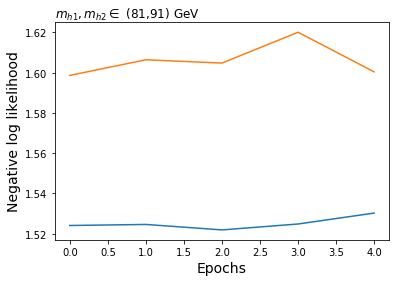

In [52]:
plt.plot(losses['train'],label='train')
plt.plot(losses['val'],label='validation')
plt.plot()
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Negative log likelihood',fontsize=14)

ax = plt.gca()
plt.text(0,1,mh_tag,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)


plt.savefig(f'figures/interp1/loss_rnvp_mh1_{mh1_min:.0f}_{mh1_max:.0f}_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',
            bbox_inches='tight')
plt.show()

In [51]:
mh1_min

81

I also want to visualize what the flow is doing in modeling this first bin.

In [53]:
s,n = model.sample(int(1e6),returnNoise=True)
s = s.cpu().detach().numpy()
n = n.cpu().detach().numpy()

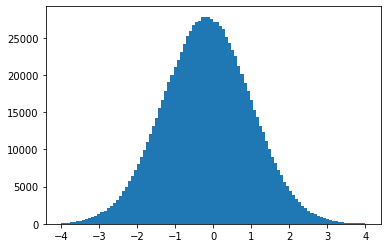

In [54]:
plt.hist(s,100,(-4,4))

plt.show()

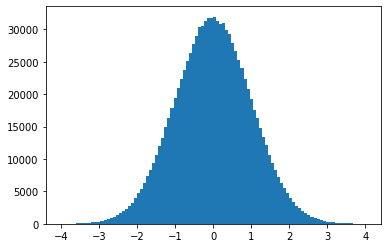

In [55]:
plt.hist(n,100,(-4,4))

plt.show()

Color code the noise as well.

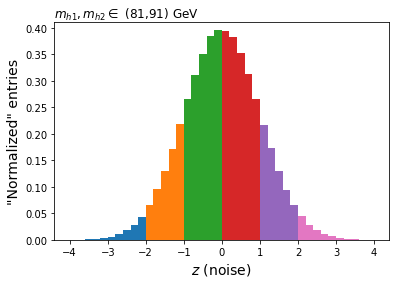

In [149]:
edges = [-4,-2,-1,0,1,2,4]

hs = []
colors = ['C0','C1','C2','C3','C4','C6']

for zmin, zmax in zip(edges[:-1],edges[1:]):
    
    hs.append(n[(n>=zmin) & (n<zmax)])
    
plt.hist(hs,40,(-4,4),color=colors,stacked=True,density=True,label='noise')
    
plt.xlabel('$z$ (noise)',fontsize=14)
plt.ylabel('"Normalized" entries',fontsize=14)
plt.ylim(0,.41)  

ax = plt.gca()
plt.text(0,1,mh_tag,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig(f'figures/interp1/noise_mh1_{mh1_min:.0f}_{mh1_max:.0f}_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',
            bbox_inches='tight')

plt.show()

In [135]:
# Fit the full plane - but transform the individual pixel
ntag=4
cols = ['m_hh_125_log']

scalarX = StandardScaler()
x_plane = df.loc[(df.ntag == ntag) & plane_mask,cols].values
scalarX.fit(x_plane)

x_bin = df.loc[(df.ntag == ntag) & bin_mask,cols].values
x = scalarX.transform(x_bin,copy=True)


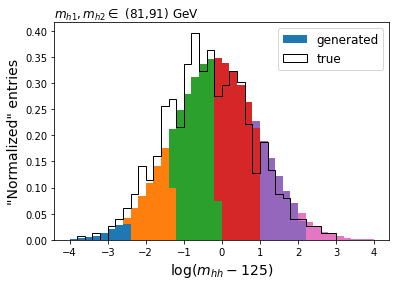

In [150]:
edges = [-4,-2,-1,0,1,2,4]

hs = []
colors = ['C0','C1','C2','C3','C4','C6']

for zmin, zmax in zip(edges[:-1],edges[1:]):
    
    hs.append(s[(n>=zmin) & (n<zmax)])
    
plt.hist(hs,40,(-4,4),color=colors,stacked=True,density=True,label='generated')
 
plt.hist(x,40,(-4,4),color='k',density=True,histtype='step',label='true')
    
plt.xlabel('$\log (m_{hh}-125)$',fontsize=14)
plt.ylabel('"Normalized" entries',fontsize=14)
plt.legend(fontsize=12)
    
ax = plt.gca()
plt.text(0,1,mh_tag,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig(f'figures/interp1/genSamples_mh1_{mh1_min:.0f}_{mh1_max:.0f}_mh2_{mh2_min:.0f}_{mh2_max:.0f}.pdf',
            bbox_inches='tight')

plt.show()

Let's overlay the data as well, and add some labels to the plot

## Learn to morph!

Use the distribution above as a **base distribution** and morph it into the next $m_{h1}$ bin!

In [61]:
tr2, val2 = getDataLoaders(df, ntag=4, bin_mask=bin_mask, bin2_mask=bin2_mask, plane_mask=plane_mask)

In [129]:
modules = []

for _ in range(1):
        modules += [
            fnn.CouplingLayer(num_inputs, num_hidden, mask, num_cond_inputs),
            fnn.BatchNormFlow(num_inputs)
        ]
               
model2 = fnn.FlowTwoSteps(*modules)

for module in model2.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

model2.to('cpu')

optimizer2 = optim.Adam(model2.parameters(), lr=1e-4, weight_decay=1e-6)

In [82]:
for i, data in enumerate(tr2):
    break

In [111]:
data[0].to('cpu')

tensor([[-2.0137],
        [-2.4786],
        [ 0.2925],
        [-0.9515],
        [-1.6366],
        [ 0.5930],
        [ 0.7724],
        [-1.2772],
        [ 0.3893],
        [-0.3798],
        [-0.7083],
        [ 0.2980],
        [-1.2436],
        [-1.1591],
        [ 0.2240],
        [ 1.1279],
        [ 1.3475],
        [-0.2172],
        [-1.5357],
        [ 0.3980],
        [-0.5655],
        [ 2.6812],
        [-2.0933],
        [-0.0174],
        [-1.8841],
        [ 0.4509],
        [-0.6005],
        [-0.0799],
        [-0.0200],
        [ 0.7072],
        [ 0.8449],
        [ 0.5901],
        [-2.1248],
        [ 0.7889],
        [-0.7296],
        [-0.2442],
        [ 1.4331],
        [ 0.3311],
        [ 1.0952],
        [-1.1684],
        [ 0.5113],
        [ 1.3791],
        [-0.8466],
        [-1.5105],
        [ 1.0278],
        [ 0.1085],
        [-0.3704],
        [-0.7450],
        [-1.1779],
        [ 0.2302],
        [-1.1949],
        [-2.0121],
        [ 0.

In [109]:
data[1].to('cpu')

tensor([[-1.6572],
        [-1.0549],
        [-1.9935],
        [-0.0056],
        [ 0.6557],
        [-0.0497],
        [ 0.3883],
        [ 1.2537],
        [ 1.5641],
        [-0.4065],
        [-0.9903],
        [-0.1430],
        [ 2.6378],
        [ 0.4356],
        [-2.2271],
        [-0.4808],
        [-1.6444],
        [-0.1374],
        [-0.1984],
        [ 0.4782],
        [ 2.5147],
        [-1.9944],
        [-0.5308],
        [-1.4999],
        [-0.9647],
        [-0.3280],
        [-1.1807],
        [-0.3674],
        [-0.8394],
        [-1.7936],
        [-1.1715],
        [-1.6935],
        [-1.1224],
        [-1.4465],
        [-1.0424],
        [-1.6953],
        [ 0.6666],
        [-1.1237],
        [-1.2761],
        [-0.6637],
        [-0.9264],
        [ 0.4313],
        [-1.1338],
        [ 0.4072],
        [-2.6902],
        [-0.0166],
        [-1.1596],
        [-1.4804],
        [ 0.7339],
        [-0.3216],
        [-0.7489],
        [-0.0908],
        [-1.

In [120]:
mask=mask.to('cpu')

In [121]:
mask.device

device(type='cpu')

In [130]:
model2([data[0].to('cpu'),data[1].to('cpu')])

inputs[-1] torch.Size([128, 1])
inputs[0] torch.Size([128, 1])


RuntimeError: expected device cpu and dtype Double but got device cpu and dtype Float

In [128]:
mask.device

device(type='cpu')

In [71]:
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model2
global_step = 0

nEpochs = 5
losses = {key: [] for key in ['train','val']}

modelName = "models/rnvp_m_hh_125_log_two_bins.pt"

for epoch in range(nEpochs):
    print('\nEpoch: {}'.format(epoch))

    train_loss = train(epoch, model2, tr2, device, optimizer2)
    losses['train'].append(train_loss)
    validation_loss = validate(epoch, model2, val2, device)
    losses['val'].append(validation_loss)
    
    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        torch.save(model2.state_dict(), modelName)
    
    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))
    
    
# Load the model with the best validation loss
model2.load_state_dict(torch.load(modelName))





  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0


RuntimeError: size mismatch, m1: [128 x 2], m2: [1 x 64] at /opt/conda/conda-bld/pytorch_1565272279342/work/aten/src/THC/generic/THCTensorMathBlas.cu:273

In [73]:
model2

FlowSequential(
  (0): CouplingLayer(
    (scale_net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
    (translate_net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (1): BatchNormFlow()
)